In [1]:
import os
import sys
import glob
import argparse
from matplotlib import pyplot as plt
import multiprocessing
import tools.image as T

from keras import __version__
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
#from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from inception_v4 import InceptionV4, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from types import SimpleNamespace

IM_WIDTH, IM_HEIGHT = 299, 299 # fixed size for InceptionV3, Inception ResNet V2 and Inception V4
EPOCHS = 150
BAT_SIZE = 16
FC_SIZE = 1024
NB_LAYERS_TO_FREEZE = 172 # 165 ou ou 197

#NB_LAYERS_TO_FREEZE = 249 # Inception V3
#NB_LAYERS_TO_FREEZE = 618 # Inception ResNet V2
#NB_LAYERS_TO_FREEZE = 369 # Inception V4

Using TensorFlow backend.


In [2]:
def get_callbacks(weights_path='weights_checkpoint.h5', patience=30, monitor='val_loss'):
    early_stopping = EarlyStopping(verbose=1, patience=patience, monitor=monitor, min_delta=0.01)
    model_checkpoint = ModelCheckpoint(weights_path,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       monitor=monitor)
    return [early_stopping, model_checkpoint]

def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt


def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])


def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet

    Args:
        base_model: keras model excluding top
        nb_classes: # of classes

    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation = 'relu')(x) # new FC layer, random init
    predictions = Dense(nb_classes, activation = 'softmax')(x) # new softmax layer
    model = Model(inputs = base_model.input, outputs = predictions)
    return model


def setup_to_finetune(model):
    """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.

    note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch

    Args:
        model: keras model
    """
    for layer in model.layers[:NB_LAYERS_TO_FREEZE]:
         layer.trainable = False
    for layer in model.layers[NB_LAYERS_TO_FREEZE:]:
         layer.trainable = True
    model.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])


def train(args):
    """Use transfer learning and fine-tuning to train a network on a new dataset"""
    nb_train_samples = get_nb_files(args.train_dir)
    nb_classes = len(glob.glob(args.train_dir + "/*"))
    nb_val_samples = get_nb_files(args.val_dir)
    epochs = int(args.epochs)
    batch_size = int(args.batch_size)
    
    '''try:
        pool.terminate()
    except:
        pass
    n_process = 6
    pool = multiprocessing.Pool(processes = n_process)'''

    # data prep
    train_datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        rotation_range = 90,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        #pool = pool
    )
    test_datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        #rotation_range = 90,
        #width_shift_range = 0.2,
        #height_shift_range = 0.2,
        #shear_range = 0.2,
        #zoom_range = 0.2,
        #horizontal_flip = True,
        #pool = pool
    )

    train_generator = train_datagen.flow_from_directory(
        args.train_dir,
        target_size = (IM_WIDTH, IM_HEIGHT),
        batch_size = batch_size,
    )

    validation_generator = test_datagen.flow_from_directory(
        args.val_dir,
        target_size = (IM_WIDTH, IM_HEIGHT),
        batch_size = batch_size,
    )

    # setup model
    #base_model = InceptionV3(weights = 'imagenet', include_top = False)
    #base_model = InceptionResNetV2(weights = 'imagenet', include_top = False)
    base_model = InceptionV4(weights = 'imagenet', include_top = False)
    model = add_new_last_layer(base_model, nb_classes)

    # transfer learning
    setup_to_transfer_learn(model, base_model)

    history_tl = model.fit_generator(
        train_generator,
        epochs = epochs,
        steps_per_epoch = nb_train_samples / batch_size,
        validation_data = validation_generator,
        validation_steps = nb_val_samples / batch_size,
        class_weight = 'auto',
        callbacks = get_callbacks())

    # fine-tuning
    setup_to_finetune(model)

    history_ft = model.fit_generator(
        train_generator,
        epochs = epochs,
        steps_per_epoch = nb_train_samples / batch_size,
        validation_data = validation_generator,
        validation_steps = nb_val_samples / batch_size,
        class_weight = 'auto',
        callbacks = get_callbacks())

    model.save(args.output_model_file)

    if args.plot:
        plot_training(history_ft)


def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

Found 8000 images belonging to 30 classes.
Found 2000 images belonging to 30 classes.
Epoch 1/150
500/500 [==============================] - 233s 466ms/step - loss: 2.7941 - acc: 0.4114 - val_loss: 2.1201 - val_acc: 0.5940
Epoch 2/150
500/500 [==============================] - 213s 425ms/step - loss: 2.0699 - acc: 0.6000 - val_loss: 1.8357 - val_acc: 0.6835
Epoch 3/150
500/500 [==============================] - 215s 429ms/step - loss: 1.9149 - acc: 0.6485 - val_loss: 1.7293 - val_acc: 0.7310
Epoch 4/150
500/500 [==============================] - 213s 426ms/step - loss: 1.8359 - acc: 0.6679 - val_loss: 1.7020 - val_acc: 0.7290
Epoch 5/150
500/500 [==============================] - 213s 426ms/step - loss: 1.7953 - acc: 0.6871 - val_loss: 1.5538 - val_acc: 0.7700
Epoch 6/150
500/500 [==============================] - 212s 424ms/step - loss: 1.7571 - acc: 0.6994 - val_loss: 1.6376 - val_acc: 0.7570
Epoch 7/150
500/500 [==============================] - 210s 421ms/step - loss: 1.7430 - acc:

500/500 [==============================] - 311s 622ms/step - loss: 0.8491 - acc: 0.9670 - val_loss: 1.0624 - val_acc: 0.9260
Epoch 25/150
500/500 [==============================] - 308s 616ms/step - loss: 0.8653 - acc: 0.9593 - val_loss: 1.0622 - val_acc: 0.9310
Epoch 26/150
500/500 [==============================] - 310s 620ms/step - loss: 0.8462 - acc: 0.9666 - val_loss: 1.0271 - val_acc: 0.9320
Epoch 27/150
500/500 [==============================] - 307s 614ms/step - loss: 0.8484 - acc: 0.9661 - val_loss: 1.0356 - val_acc: 0.9315
Epoch 28/150
500/500 [==============================] - 307s 614ms/step - loss: 0.8400 - acc: 0.9699 - val_loss: 1.0907 - val_acc: 0.9350
Epoch 29/150
500/500 [==============================] - 308s 615ms/step - loss: 0.8443 - acc: 0.9637 - val_loss: 1.0875 - val_acc: 0.9320
Epoch 30/150
500/500 [==============================] - 307s 615ms/step - loss: 0.8310 - acc: 0.9704 - val_loss: 1.0739 - val_acc: 0.9330
Epoch 31/150
500/500 [=========================

500/500 [==============================] - 308s 615ms/step - loss: 0.7772 - acc: 0.9886 - val_loss: 1.0572 - val_acc: 0.9405
Epoch 84/150
500/500 [==============================] - 307s 614ms/step - loss: 0.7764 - acc: 0.9894 - val_loss: 1.0641 - val_acc: 0.9425
Epoch 85/150
500/500 [==============================] - 306s 613ms/step - loss: 0.7727 - acc: 0.9900 - val_loss: 1.0549 - val_acc: 0.9470
Epoch 86/150
500/500 [==============================] - 308s 615ms/step - loss: 0.7765 - acc: 0.9885 - val_loss: 1.0399 - val_acc: 0.9460
Epoch 87/150
500/500 [==============================] - 310s 619ms/step - loss: 0.7743 - acc: 0.9900 - val_loss: 1.0705 - val_acc: 0.9440
Epoch 88/150
500/500 [==============================] - 311s 621ms/step - loss: 0.7750 - acc: 0.9884 - val_loss: 1.0606 - val_acc: 0.9435
Epoch 89/150
500/500 [==============================] - 309s 617ms/step - loss: 0.7693 - acc: 0.9920 - val_loss: 1.0701 - val_acc: 0.9420
Epoch 90/150
500/500 [=========================

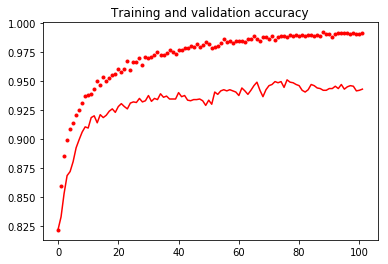

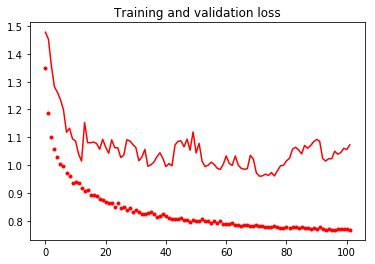

In [3]:
args = SimpleNamespace(
    train_dir = "C:\\AID\\AID-split\\train",
    val_dir = "C:\\AID\\AID-split\\test",
    #output_model_file = "inceptionv3-ft-2.h5",
    #output_model_file = "inception_resnet_v2-ft.h5",
    output_model_file = "inceptionv4-ft.h5",
    epochs = EPOCHS,
    batch_size = BAT_SIZE,
    plot = True)

if (not os.path.exists(args.train_dir)) or (not os.path.exists(args.val_dir)):
    print("directories do not exist")
    sys.exit(1)

train(args)

In [ ]:
from inception_v4 import InceptionV4, preprocess_input
base_model = InceptionV4(weights = 'imagenet', include_top = False)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)